# jit inference dev
notebook for developing jitted inference (pitchfork predict function compiled to save time)

In [1]:
import numpy as np
import jax
import jax.numpy as jnp

import tinygp
from tinygp import GaussianProcess
from tinygp import kernels

import json
import pickle
import pandas as pd
from functools import partial

import ultranest

from scripts import numpy_compile, jax_compile, prior_funcs

##plotting
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import corner

plt.style.use("Solarize_Light2")
plt.rcParams.update({"axes.edgecolor": "black"})
plt.rcParams.update({"text.color": "black"})
plt.rcParams.update({"axes.labelcolor": "black"})
plt.rcParams.update({"xtick.color": "black"})
plt.rcParams.update({"ytick.color": "black"})
plt.rcParams.update({"font.family": "monospace"})

## import pitchfork and solar info

In [2]:
with open('pitchfork/pitchfork.json', 'r') as fp:
    pitchfork_dict = json.load(fp)
    
pitchfork = numpy_compile(pitchfork_dict)

jpitchfork = jax_compile(pitchfork_dict)

with open('pitchfork/pitchfork_info.json', 'r') as fp:
    pitchfork_info = json.load(fp)

pitchfork_cov = np.loadtxt('pitchfork/pitchfork_covariance.txt')

In [3]:
#parameters for star, [value,unc], NaN for not found/published
#1 : Lyttle
#2 : Asplund 2020
#3 : 
#4 : 

star_name = 'Sun-as-the-Sun'

star_dict={}

star_dict['initial_mass']=[1, 0.001] #1
star_dict['initial_Zinit']= [0.0154, 0.002] #2
star_dict['initial_Yinit']= [0.2766, 0.01] #2
star_dict['initial_MLT']= [1.92, 0.09] #2
star_dict['star_age']=[4.6, 0.1] #1

star_dict['calc_effective_T']=[5777, 20] #1
star_dict['radius']=[1, 0.001] #1
star_dict['luminosity']=[1, 0.001] #1
star_dict['star_feh']=[0, 0.01] #1

#############
star_dict['nu_0_6']= [972.615, 0.002]
star_dict['nu_0_7']= [1117.993, 0.004]
star_dict['nu_0_8']= [1263.198, 0.005]
star_dict['nu_0_9']= [1407.472, 0.006]
star_dict['nu_0_10']= [1548.336, 0.007]
star_dict['nu_0_11']= [1686.594, 0.012]
star_dict['nu_0_12']= [1822.202, 0.012]
star_dict['nu_0_13']= [1957.452, 0.012]
star_dict['nu_0_14']= [2093.518, 0.013]
star_dict['nu_0_15']= [2228.749, 0.014]
star_dict['nu_0_16']= [2362.788, 0.016]
star_dict['nu_0_17']= [2496.180, 0.017]
star_dict['nu_0_18']= [2629.668, 0.015]
star_dict['nu_0_19']= [2764.142, 0.015]
star_dict['nu_0_20']= [2899.022, 0.013]
star_dict['nu_0_21']= [3033.754, 0.014]
star_dict['nu_0_22']= [3168.618, 0.017]
star_dict['nu_0_23']= [3303.520, 0.021]
star_dict['nu_0_24']= [3438.992, 0.030]
star_dict['nu_0_25']= [3574.893, 0.048]
star_dict['nu_0_26']= [3710.717, 0.088]
star_dict['nu_0_27']= [3846.993, 0.177]
star_dict['nu_0_28']= [3984.214, 0.323]

##############

star_dict['dnu'] = [135.1, 0.2] #1
star_dict['nu_max'] = [3141, 12]

with open(f'{star_name}.json', 'w') as fp:
    json.dump(star_dict, fp)

star_dict

{'initial_mass': [1, 0.001],
 'initial_Zinit': [0.0154, 0.002],
 'initial_Yinit': [0.2766, 0.01],
 'initial_MLT': [1.92, 0.09],
 'star_age': [4.6, 0.1],
 'calc_effective_T': [5777, 20],
 'radius': [1, 0.001],
 'luminosity': [1, 0.001],
 'star_feh': [0, 0.01],
 'nu_0_6': [972.615, 0.002],
 'nu_0_7': [1117.993, 0.004],
 'nu_0_8': [1263.198, 0.005],
 'nu_0_9': [1407.472, 0.006],
 'nu_0_10': [1548.336, 0.007],
 'nu_0_11': [1686.594, 0.012],
 'nu_0_12': [1822.202, 0.012],
 'nu_0_13': [1957.452, 0.012],
 'nu_0_14': [2093.518, 0.013],
 'nu_0_15': [2228.749, 0.014],
 'nu_0_16': [2362.788, 0.016],
 'nu_0_17': [2496.18, 0.017],
 'nu_0_18': [2629.668, 0.015],
 'nu_0_19': [2764.142, 0.015],
 'nu_0_20': [2899.022, 0.013],
 'nu_0_21': [3033.754, 0.014],
 'nu_0_22': [3168.618, 0.017],
 'nu_0_23': [3303.52, 0.021],
 'nu_0_24': [3438.992, 0.03],
 'nu_0_25': [3574.893, 0.048],
 'nu_0_26': [3710.717, 0.088],
 'nu_0_27': [3846.993, 0.177],
 'nu_0_28': [3984.214, 0.323],
 'dnu': [135.1, 0.2],
 'nu_max': [3

## define priors

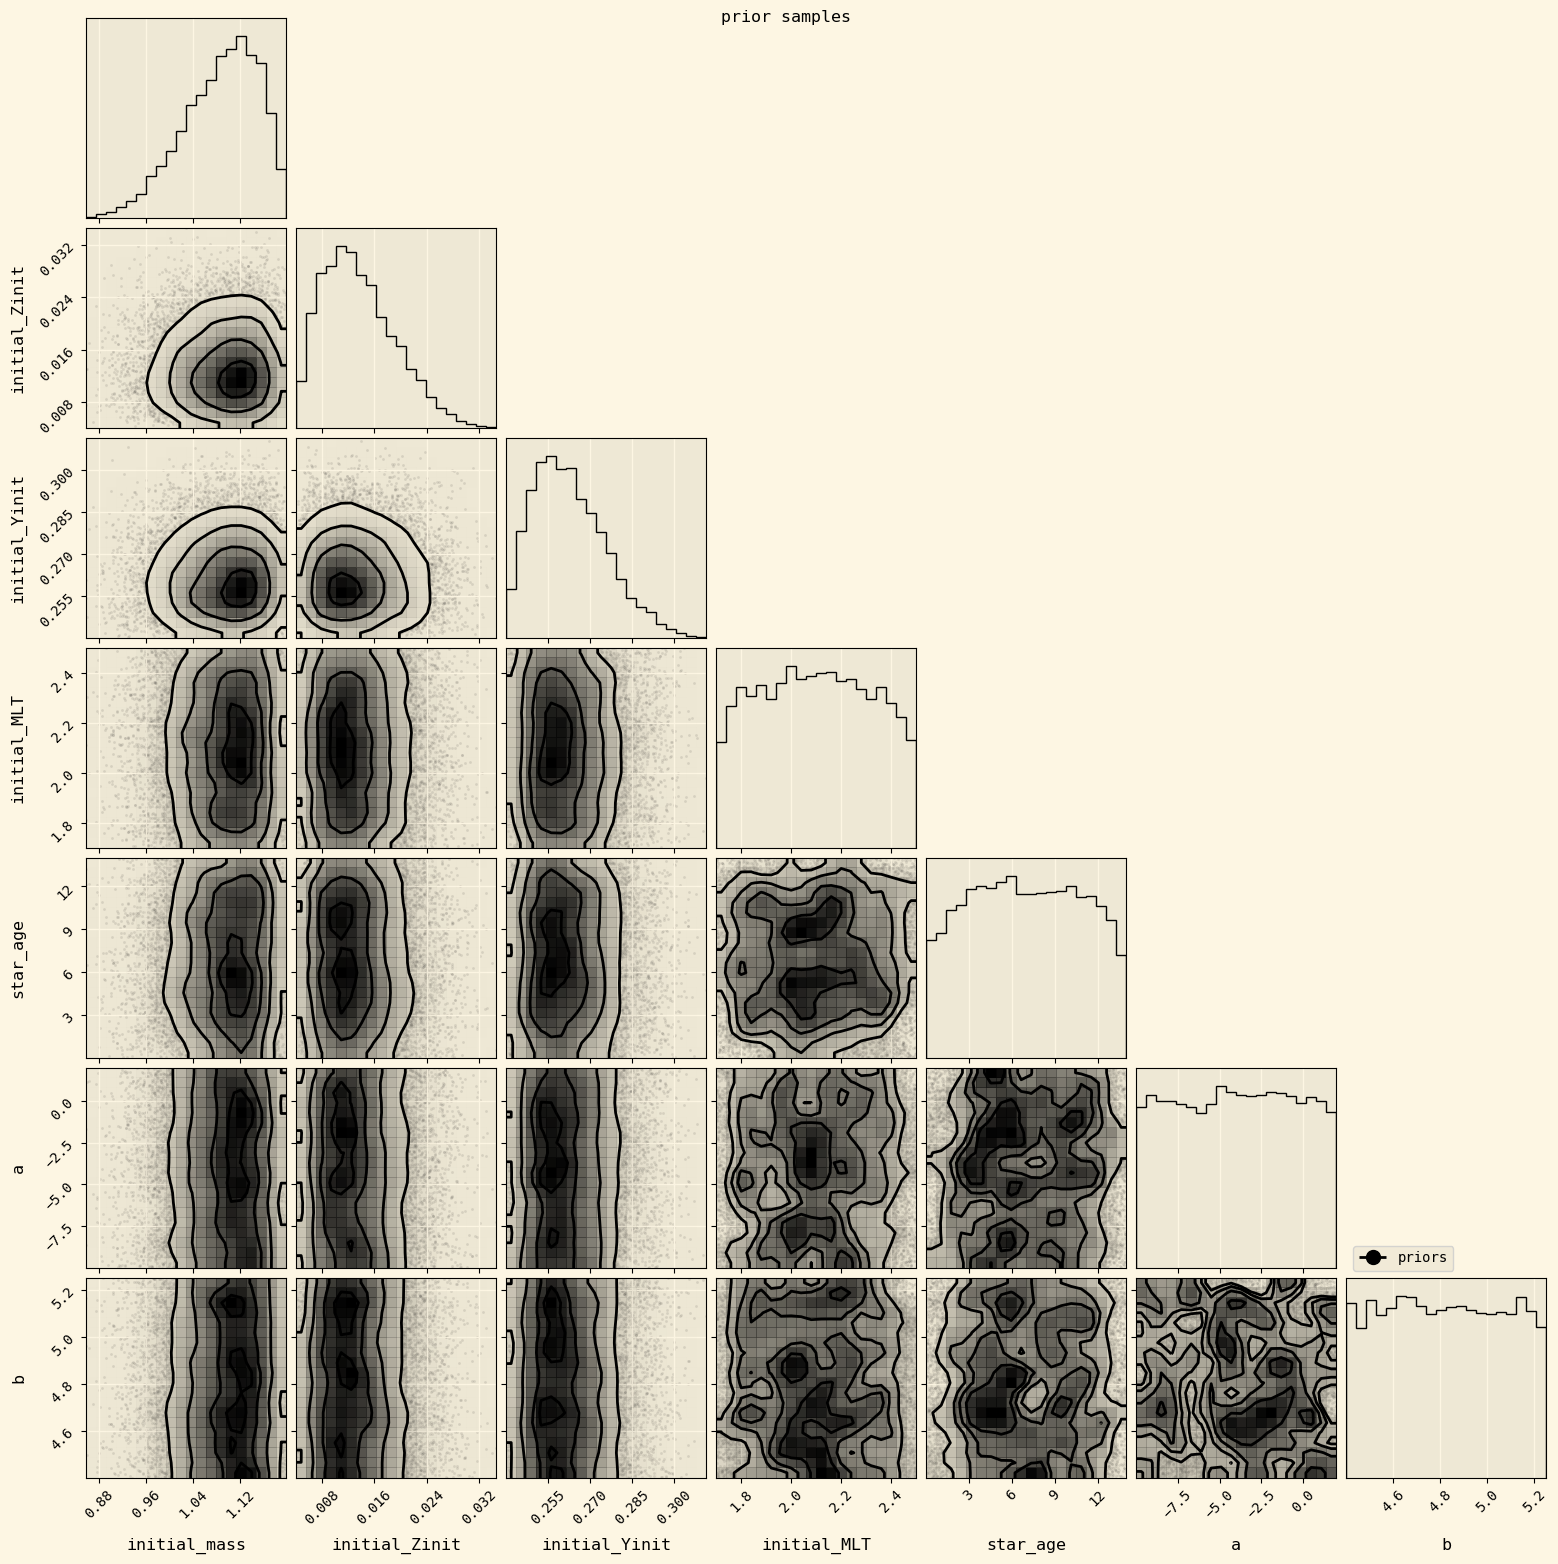

In [4]:
labels = ['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age', 'a', 'b']

mass_prior = prior_funcs.custom_beta_prior(0.8, 1.2, a=5, b=2)

Zinit_prior = prior_funcs.custom_beta_prior(0.004, 0.038, a=2, b=5)

Yinit_prior = prior_funcs.custom_beta_prior(0.24, 0.32, a=2, b=5)

MLT_prior = prior_funcs.custom_beta_prior(1.7, 2.5, a=1.2, b=1.2)

age_prior = prior_funcs.custom_beta_prior(0.03, 14, a=1.2, b=1.2)

a_prior = prior_funcs.custom_uniform_prior(-10, 2)

b_prior = prior_funcs.custom_uniform_prior(4.4, 5.25)

priors = [mass_prior, Zinit_prior, Yinit_prior, MLT_prior, age_prior, a_prior, b_prior]

size = 10000
plot_prior_samples = np.array([prior.rvs(size=size) for prior in priors])
legend_labels = []
corner_color = 'black'
corner.corner(plot_prior_samples.T, labels = labels, color=corner_color, hist_kwargs={'density':True}, smooth=True);
legend_labels = legend_labels + [Line2D([0], [0], marker='o', color =corner_color, markerfacecolor = corner_color, markersize=10, label='priors')]
plt.suptitle('prior samples')
plt.legend(handles=legend_labels, bbox_to_anchor=(0., 1.0, 1., .0), loc=0)
plt.show()

In [31]:
star_json = f'{star_name}.json'

star_df = pd.read_json(star_json).dropna(axis=1)

star_vals_df = star_df.iloc[[0]]

star_uncs_df = star_df.iloc[[1]]

star_obs_vals_df = star_vals_df.drop(['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age','radius', 'dnu', 'nu_max'], axis=1)

star_obs_uncs_df = star_uncs_df.drop(['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age','radius', 'dnu', 'nu_max'], axis=1)

nu_max = star_df["nu_max"].values[0]

### obs matrix
star_obs_vals_df = star_vals_df.drop(['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age','radius', 'dnu', 'nu_max'], axis=1)

star_obs_uncs_df = star_uncs_df.drop(['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age','radius', 'dnu', 'nu_max'], axis=1)

sigma_obs = (star_obs_uncs_df.values[0]*star_obs_uncs_df.values[0])*(np.identity(len(star_obs_uncs_df.values[0])))

### nn matrix
sigma_nn = pitchfork_cov

n_min = int(star_obs_vals_df.drop(['calc_effective_T', 'luminosity', 'star_feh'],axis=1).columns[0].replace('nu_0_',''))
n_max = int(star_obs_vals_df.drop(['calc_effective_T', 'luminosity', 'star_feh'],axis=1).columns[-1].replace('nu_0_',''))

sigma_nn_mask = np.zeros(len(sigma_nn), dtype=bool)
sigma_nn_mask[:3] = True
sigma_nn_mask[n_min-3:n_max-2] = True

sigma_nn_cropped = sigma_nn[:,sigma_nn_mask][sigma_nn_mask,:]

### gp matrix
obs_freqs = star_vals_df[[f"nu_0_{i}" for i in range(n_min, n_max+1)]].iloc[0].values.flatten()

dnu = star_df['dnu'].values[0]

kernel = 4*kernels.ExpSquared(scale=7*dnu)

gp = GaussianProcess(kernel, obs_freqs, diag=1e-12)

gp_cov = tinygp.solvers.DirectSolver.init(kernel, obs_freqs, noise=tinygp.noise.Dense(value=np.zeros((len(obs_freqs),len(obs_freqs))))).covariance()

gp_cov_padded = np.pad(gp_cov, (3,0))

# add covariance matrices
sigma = sigma_nn_cropped + sigma_obs + gp_cov_padded

# sigma_inv = np.linalg.inv(sigma)

# _, log_sigma_det = np.linalg.slogdet(sigma)

sigma_L = np.linalg.cholesky(sigma)

log_sigma_det = 2 * np.sum(np.log(np.diag(sigma_L)))

In [23]:
class nested_sampler():
    def __init__(self, priors, observed_vals, pitchfork, pitchfork_info, sigma_L, log_sigma_det, nu_max, n_min=6, n_max=40, logl_scale = 1):
        # prior info       
        self.priors = priors
        self.ndim = len(priors)
        
        #observed  values
        self.n_min = n_min
        self.n_max = n_max
        self.n_slice_index = np.r_[0, 1, 2, np.arange(n_min-3, n_max-2)]
        
        self.nu_max = nu_max
        self.obs_val = observed_vals

        #unpack pichfork and info
        self.pitchfork = pitchfork
        
        self.pitchfork_info = pitchfork_info
        self.log_inputs_mean = np.array(pitchfork_info["data_scaling"]["inp_mean"][0])        
        self.log_inputs_std = np.array(pitchfork_info["data_scaling"]["inp_std"][0])
        self.log_outputs_mean = np.array(pitchfork_info["data_scaling"]["classical_out_mean"][0] + pitchfork_info["data_scaling"]["astero_out_mean"][0])        
        self.log_outputs_std = np.array(pitchfork_info["data_scaling"]["classical_out_std"][0] + pitchfork_info["data_scaling"]["astero_out_std"][0])
        self.pca_comps = np.array(pitchfork_info['custom_objects']['inverse_pca']['pca_comps'])
        self.pca_mean = np.array(pitchfork_info['custom_objects']['inverse_pca']['pca_mean'])
        
        #def constants
        self.L_sun = 3.828e+26
        self.R_sun = 6.957e+8
        self.SB_sigma = 5.670374419e-8

        #logl variables
        self.logl_scale = logl_scale
        self.logl_factor = -(len(observed_vals)*0.5*np.log(2*np.pi))-(0.5*log_sigma_det)
        self.sigma_inv = sigma_inv
        self.matmul_path = np.einsum_path('ij, jk, ik->i', np.array(observed_vals).reshape(-1,1), sigma_inv, np.array(observed_vals).reshape(-1,1), optimize='optimal')[0]

    def ptform(self, u):
        theta = np.array([self.priors[i].ppf(u[:,i]) for i in range(self.ndim)]).T
        return theta

    def surf_corr(self, freqs, a, b):
        return freqs + a*((freqs/self.nu_max)**b)

    def pitchfork_predict(self, x):
        log_inputs = np.log10(x)
        
        standardised_log_inputs = (log_inputs - self.log_inputs_mean)/self.log_inputs_std
        
        preds = self.pitchfork.forward_pass(standardised_log_inputs)

        #pca_preds = np.tensordot(preds[1], self.pca_comps, 1) + self.pca_mean
        pca_preds = preds[1] @ self.pca_comps + self.pca_mean
        
        standardised_log_outputs = np.concatenate((preds[0], pca_preds), axis=1)

        log_outputs = (standardised_log_outputs*self.log_outputs_std) + self.log_outputs_mean

        outputs = np.empty_like(log_outputs)
        
        outputs[:, :2] = 10**log_outputs[:, :2]

        outputs[:, 2] = log_outputs[:, 2]##we want star_feh in dex

        outputs[:, 3:] = 10**log_outputs[:, 3:] 

        teff = np.array(((outputs[:,1]*self.L_sun) / (4*np.pi*self.SB_sigma*((outputs[:,0]*self.R_sun)**2)))**0.25)
        
        outputs[:,0] = teff
        
        outputs = outputs[:, self.n_slice_index]

        return outputs
    
    def logl(self, theta):

        m = self.pitchfork_predict(theta[:,:-2])

        a_arr = np.expand_dims(theta[:,-2],1)

        b_arr = np.expand_dims(theta[:,-1],1)

        m_corrected = m.copy()
        
        m_corrected[:,3:] = self.surf_corr(m[:,3:],a_arr, b_arr)
        
        residual_matrix = np.array(m_corrected-self.obs_val)
        

        ll = self.logl_factor-0.5*np.einsum('ij, jk, ik->i', residual_matrix, self.sigma_inv, residual_matrix, optimize=self.matmul_path)

        return self.logl_scale * ll

    def __call__(self, ndraw_min, ndraw_max, draw_multiple=True):

        self.sampler = ultranest.ReactiveNestedSampler(['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age','a','b'], self.logl, transform = self.ptform, vectorized=True, ndraw_min=ndraw_min, ndraw_max=ndraw_max, draw_multiple=draw_multiple)
        
        return self.sampler

In [24]:
%%time
ndraw_min=2**15
ndraw_max=2**15
min_num_live_points = 400

print(star_df[['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age']].iloc[[0]].to_markdown(index=False))
sampler = nested_sampler(priors=priors, observed_vals=star_obs_vals_df.values[0], pitchfork=pitchfork, pitchfork_info = pitchfork_info, log_sigma_det=log_sigma_det, sigma_inv=sigma_inv, nu_max = nu_max, n_min=n_min, n_max=n_max, logl_scale=1)
results = sampler(ndraw_min, ndraw_max).run(min_num_live_points=min_num_live_points, cluster_num_live_points=.1*min_num_live_points, frac_remain=.001)#, max_ncalls=5e6)

|   initial_mass |   initial_Zinit |   initial_Yinit |   initial_MLT |   star_age |
|---------------:|----------------:|----------------:|--------------:|-----------:|
|              1 |          0.0154 |          0.2766 |          1.92 |        4.6 |
[ultranest] Sampling 400 live points from prior ...


/home/oxs235/repos/ojscutt/pitchfork/scripts/wtf_compile.py:59: RuntimeWarning: overflow encountered in exp
  return self.np.where(x >= 0, x, self.np.exp(x)-1)


Z=-24.0(0.37%) | Like=-10.95..-2.82 [-13.9604..-10.8306] | it/evals=4746/97763 eff=4.8745% N=400       0      0 

/home/oxs235/miniconda3/envs/pitchfork/lib/python3.13/site-packages/ultranest/integrator.py:1903: UserWarning: Sampling from region seems inefficient (2/32768 accepted in iteration 21). To improve efficiency, modify the transformation so that the current live points are ellipsoidal, or use a stepsampler, or set frac_remain to a lower number (e.g., 0.5) to terminate earlier.
  u, v, logl, nc, quality = self._refill_samples(Lmin, ndraw, nit)


[ultranest] Explored until L=-2  75 [-2.0032..-1.9547] | it/evals=9520/189401 eff=5.0370% N=400  
[ultranest] Likelihood function evaluations: 189576
[ultranest]   logZ = -18.29 +- 0.1242
[ultranest] Effective samples strategy satisfied (ESS = 2411.3, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.12, need <0.5)
[ultranest]   logZ error budget: single: 0.18 bs:0.12 tail:0.00 total:0.12 required:<0.50
[ultranest] done iterating.
CPU times: user 6min 51s, sys: 502 ms, total: 6min 52s
Wall time: 1min 53s


In [164]:
def surf_corr(freqs, a, b, nu_max):
    return freqs + a*((freqs/nu_max)**b)
    
@partial(jax.jit, static_argnums=0)
def compiled_logl(static_params, x):
        #observed  values
        n_min = static_params['n_min']
        n_max = static_params['n_max']
        nu_max = static_params['nu_max']
        observed_vals = static_params['observed_vals']

        #unpack pichfork and info
        jpitchfork = static_params['jpitchfork']
    
        log_inputs_mean = static_params['']    
        log_inputs_std = jnp.array(pitchfork_info["data_scaling"]["inp_std"][0])
        log_outputs_mean = jnp.array(pitchfork_info["data_scaling"]["classical_out_mean"][0] + pitchfork_info["data_scaling"]["astero_out_mean"][0])        
        log_outputs_std = jnp.array(pitchfork_info["data_scaling"]["classical_out_std"][0] + pitchfork_info["data_scaling"]["astero_out_std"][0])
        pca_comps = jnp.array(pitchfork_info['custom_objects']['inverse_pca']['pca_comps'])
        pca_mean = jnp.array(pitchfork_info['custom_objects']['inverse_pca']['pca_mean'])
        
        #def constants
        L_sun = 3.828e+26
        R_sun = 6.957e+8
        SB_sigma = 5.670374419e-8

        #logl variables
        logl_scale = logl_scale
        logl_factor = -(len(observed_vals)*0.5*jnp.log(2*jnp.pi))-(0.5*log_sigma_det)
        sigma_inv = sigma_inv
        matmul_path = jnp.einsum_path('ij, jk, ik->i', jnp.array(observed_vals).reshape(-1,1), sigma_inv, jnp.array(observed_vals).reshape(-1,1), optimize='optimal')[0]

    


class jnested_sampler():
    def __init__(self, priors, observed_vals, jpitchfork, pitchfork_info, log_sigma_det, sigma_inv, nu_max, n_min=6, n_max=40, logl_scale = 1):
        # prior info       
        self.priors = priors
        self.ndim = len(priors)
        
        #observed  values
        self.n_min = n_min
        self.n_max = n_max
        
        self.nu_max = nu_max
        self.obs_val = observed_vals

        #unpack pichfork and info
        self.jpitchfork = jpitchfork
        
        self.pitchfork_info = pitchfork_info
        self.log_inputs_mean = jnp.array(pitchfork_info["data_scaling"]["inp_mean"][0])        
        self.log_inputs_std_ = jnp.array(pitchfork_info["data_scaling"]["inp_std"][0])
        self.log_outputs_mean_ = jnp.array(pitchfork_info["data_scaling"]["classical_out_mean"][0] + pitchfork_info["data_scaling"]["astero_out_mean"][0])        
        self.log_outputs_std_ = jnp.array(pitchfork_info["data_scaling"]["classical_out_std"][0] + pitchfork_info["data_scaling"]["astero_out_std"][0])
        self.pca_comps_ = jnp.array(pitchfork_info['custom_objects']['inverse_pca']['pca_comps'])
        self.pca_mean_ = jnp.array(pitchfork_info['custom_objects']['inverse_pca']['pca_mean'])
        
        #def constants
        self.L_sun = 3.828e+26
        self.R_sun = 6.957e+8
        self.SB_sigma = 5.670374419e-8

        #logl variables
        self.logl_scale = logl_scale
        self.logl_factor = -(len(observed_vals)*0.5*jnp.log(2*jnp.pi))-(0.5*log_sigma_det)
        self.sigma_inv = sigma_inv
        self.matmul_path = jnp.einsum_path('ij, jk, ik->i', jnp.array(observed_vals).reshape(-1,1), sigma_inv, jnp.array(observed_vals).reshape(-1,1), optimize='optimal')[0]

        
    def ptform(self, u):
        theta = jnp.array([self.priors[i].ppf(u[:,i]) for i in range(self.ndim)]).T
        return theta



    def pitchfork_predict(self, x):
        log_inputs = jnp.log10(x)
        
        standardised_log_inputs = (log_inputs - self.log_inputs_mean)/self.log_inputs_std
        
        ### pad!
        batch_size = standardised_log_inputs.shape[0]
        
        padded_standardised_log_inputs = jnp.pad(standardised_log_inputs, ((0,2**15-batch_size),(0,0)), mode='edge')
        
        padded_preds = self.jpitchfork.jit_forward_pass(padded_standardised_log_inputs)
        print(padded_preds[0].shape)
        print(padded_preds[1].shape)
        preds = [padded_preds[i][:batch_size] for i in range(2)]
    
    
        ### unpad!
        
        pca_preds = jnp.tensordot(preds[1], self.pca_comps, 1) + self.pca_mean
        
        standardised_log_outputs = jnp.concatenate((jnp.array(preds[0]), pca_preds), axis=1)
        
        log_outputs = (standardised_log_outputs*self.log_outputs_std) + self.log_outputs_mean
        
        outputs = 10**log_outputs
        
        outputs[:,2] = log_outputs[:,2] ##we want star_feh in dex

        teff = jnp.array(((outputs[:,1]*self.L_sun) / (4*jnp.pi*self.SB_sigma*((outputs[:,0]*self.R_sun)**2)))**0.25)
        
        outputs[:,0] = teff
        
        outputs = jnp.concatenate((jnp.array(outputs[:,:3]), jnp.array(outputs[:,self.n_min-3:self.n_max-2])), axis=1)

        return outputs
    
    def logl(self, theta):

        m = self.pitchfork_predict(theta[:,:-2])

        a_arr = np.expand_dims(theta[:,-2],1)

        b_arr = np.expand_dims(theta[:,-1],1)

        m_corrected = m.copy()
        
        m_corrected[:,3:] = self.surf_corr(m[:,3:],a_arr, b_arr)
        
        residual_matrix = np.array(m_corrected-self.obs_val)

        ll = self.logl_factor-0.5*np.einsum('ij, jk, ik->i', residual_matrix, self.sigma_inv, residual_matrix, optimize=self.matmul_path)

        return self.logl_scale * ll

    def __call__(self, ndraw_min, ndraw_max, draw_multiple=True):

        self.sampler = ultranest.ReactiveNestedSampler(['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age','a','b'], self.logl, transform = self.ptform, vectorized=True, ndraw_min=ndraw_min, ndraw_max=ndraw_max, draw_multiple=draw_multiple)
        
        return self.sampler



In [29]:
x = np.array([[1,2,3],[4,5,6],[7,8,9]])

y = np.array([[10,11,12],[13,14,15],[16,17,18]])

print(x) 
print(y)

[[1 2 3]
 [4 5 6]
 [7 8 9]]
[[10 11 12]
 [13 14 15]
 [16 17 18]]


In [50]:
%%time
sigma_L = np.linalg.cholesky(sigma);

CPU times: user 141 μs, sys: 0 ns, total: 141 μs
Wall time: 132 μs


In [55]:
y = pitchfork.forward_pass(np.array([[0.5,0.5,0.5,0.5,0.5]]))
#y = np.concatenate((y[0], y[1]), axis=1)

In [52]:
%%time
z = np.linalg.solve(sigma_L, y[0])

CPU times: user 78 μs, sys: 4 μs, total: 82 μs
Wall time: 92.5 μs


ValueError: solve1: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (m,m),(m)->(m) (size 18 is different from 26)

In [57]:
y

[array([[0.45746291, 0.55022404, 0.37583447]]),
 array([[ 2.42869059e+00, -2.09924402e-02, -2.91607387e-02,
         -6.30696148e-03, -1.37554752e-03,  1.22286922e-03,
          4.84569803e-03,  2.07647610e-03,  2.68109677e-03,
          9.62887053e-04, -6.12263785e-04,  1.05727241e-03,
          1.32305702e-03, -1.92868063e-03, -1.74395222e-03]])]

In [49]:
sigma

array([[ 4.33594490e+02,  4.64832553e-02,  1.42262174e-04,
         1.25379804e-01,  9.81799257e-02,  4.00510442e-02,
         4.45782814e-02,  1.92282069e-02,  2.97538887e-02,
         5.19690417e-02,  5.93010129e-02,  6.23726234e-02,
         6.73373780e-02,  6.95346333e-02,  5.29334078e-02,
         3.64053492e-02,  3.79585010e-02,  5.45954792e-02,
         6.74722290e-02,  8.43090660e-02,  8.96065901e-02,
         7.87466249e-02,  7.22710412e-02,  1.20846090e-01,
         1.34297041e-01,  1.11639466e-01],
       [ 4.64832553e-02,  1.72387545e-04, -2.05424125e-08,
         1.91819327e-04,  2.53087048e-06, -1.91294211e-05,
        -4.67603596e-05, -9.31887646e-05, -6.39183162e-05,
        -4.96540557e-05, -6.22213984e-05, -6.25264293e-05,
        -4.97403007e-05, -5.69728855e-05, -9.75904295e-05,
        -1.20492190e-04, -1.24889656e-04, -1.03221576e-04,
        -8.42017943e-05, -6.17798781e-05, -4.13123884e-05,
        -4.79971671e-05, -4.76382124e-05,  5.85867198e-06,
         4.35